In [420]:
import os
import json
import pandas as pd

In [422]:
%cd '/home/myilmaz/devel/551982_1475446_bundle_archive/'

/home/myilmaz/devel/551982_1475446_bundle_archive


## Papers  researching chronic kidney disease as a comorbidity risk

In [292]:
kag=pd.read_csv('Kaggle/target_tables/8_risk_factors/Chronic kidney disease.csv')

In [293]:
kag.head()

,Unnamed: 0,Date,Study,Study Link,Journal,Severe,Severe lower bound,Severe upper bound,Severe p-value,Severe Significant,...,Fatality Significant,Fatality Adjusted,Fatality Calculated,Multivariate adjustment,Study Type,Sample Size,Study Population,Added on,Critical only,Discharged vs. death?
0,0,2020-06-01,Characteristics and Outcomes of COVID-19 Patie...,http://medrxiv.org/cgi/content/short/2020.05.2...,MedRxiv,NaN,NaN,NaN,NaN,NaN,...,Significant,Not Adjusted,Calculated,NaN,Retrospective observational study,13442,New York City Health and Hospital between Marc...,NaN,N,N
1,1,2020-05-31,Clinical Features and Short-term Outcomes of E...,https://www.sciencedirect.com/science/article/...,Int J Infect Dis,NaN,NaN,NaN,NaN,NaN,...,Significant,Not Adjusted,Extracted,NaN,Retrospective observational study,204,Renmin Hospital of Wuhan University from ...,NaN,N,N
2,2,2020-05-29,A clinical risk score to identify patients wit...,https://doi.org/10.1016/j.jinf.2020.05.064,J Infect,HR=0.90,0.54,1.51,0.7,Not Significant,...,Not Significant,Not Adjusted,Extracted,NaN,Retrospective observational study,1157,King’s College Hospital and Princess Royal Uni...,NaN,Y,N
3,3,2020-05-29,The Association Between Biomarkers and Clinica...,http://medrxiv.org/cgi/content/short/2020.05.2...,MedRxiv,NaN,NaN,NaN,NaN,NaN,...,Significant,Not Adjusted,Extracted,NaN,Retrospective observational study,299,299 patients with confirmed COVID-19 positive ...,NaN,Y,N
4,4,2020-05-29,Phenotypic characteristics and prognosis of in...,https://www.ncbi.nlm.nih.gov/pubmed/32472191/,Diabetologia,OR: 0.66,0.35,1.27,NaN,Not Significant,...,Not Significant,Not Adjusted,Extracted,NaN,Retrospective observational study,1317,The CORONADO study was launched in all French ...,NaN,Y,N


In [294]:
%ls document_parses

covid.ipynb  pdf_json/  pmc_json/


In [295]:
keep=['Epidemiology, clinical course, and outcomes of critically ill adults with COVID-19 in New York City: a prospective cohort study']
arts=set(kag['Study'])-set(keep)

In [296]:
os.path.getsize('document_parses/pdf_json')/1000000

8.634368

## Filter papers that mention "creatinine" but are not listed as comorbidity risk papers

In [297]:
creat=[]
for i in os.listdir('document_parses/pdf_json'):
    save=0
    savee=0

    with open('document_parses/pdf_json/'+i) as json_file:
        data = json.load(json_file)
        if data['metadata']['title'] not in list(arts):
        
            doc=[]
            for c,j in enumerate(data['body_text']):
            
                #texts.append(data['body_text'][c]['text'])
                row=[i,data['metadata']['title'],data['body_text'][c]['section'],data['body_text'][c]['text']]
                if data['body_text'][c]['text'].lower().find('creatinine')>-1:
                    save+=1
                if data['body_text'][c]['text'].lower().find('covid-19')>-1:
                    savee+=1
                if data['body_text'][c]['text'].lower().find('covid19')>-1:
                    savee+=1
                doc.append(row)
            if save>0:
                if savee>0:
                    creat.append(doc)
        else:
            pass

In [298]:
jsons=[j[0] for i in creat for j in i]
titles=[j[1] for i in creat for j in i]
sections=[j[2] for i in creat for j in i]
text=[j[1]+'.  '+j[2]+'.  '+j[3] for i in creat for j in i]

In [299]:
creats=pd.DataFrame(None,columns=['jsons','titles','sections','text'])

In [300]:
creats.jsons=jsons
creats.titles=titles
creats.sections=sections
creats.text=text

In [301]:
creats.head()

,jsons,titles,sections,text
0,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...
1,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...
2,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...
3,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Mammary glands,Journal Pre-proof Breastfeeding and Medication...
4,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Mammary glands,Journal Pre-proof Breastfeeding and Medication...


In [302]:
docs=creats.copy(deep=True)

In [303]:
docs.drop_duplicates(keep='first',inplace=True)

In [304]:
# NUMBER OF UNIQUE DOCUMENTS IN THE DATA SET
docs['jsons'].nunique()

1524

In [306]:
docs.to_csv('covid.csv')

In [307]:
docs=pd.read_csv('covid.csv')

## Use pretrained NER model to find Problems, Tests, and Treatments

In [308]:
import os


import pyspark.sql.functions as F
from pyspark.sql.functions import monotonically_increasing_id
import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


from sparknlp.annotator import *

from sparknlp.base import *

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4


# Install Spark NLP
! pip install --ignore-installed -q spark-nlp==2.5


import sparknlp

print (sparknlp.version())

import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *

from sparknlp.base import *

from pyspark.sql.functions import monotonically_increasing_id
import pyspark.sql.functions as F
import pyspark.sql.types as t




You should consider upgrading via the '/home/myilmaz/devel/mag/notebooks/3.7env/bin/python -m pip install --upgrade pip' command.
ERROR: spark-nlp-jsl 2.5.4rc4 has requirement spark-nlp==2.5.4, but you'll have spark-nlp 2.5.0 which is incompatible.
You should consider upgrading via the '/home/myilmaz/devel/mag/notebooks/3.7env/bin/python -m pip install --upgrade pip' command.
2.5.0


In [309]:

spark=sparknlp.start()

In [310]:
docs.fillna('',inplace=True)

In [311]:
docs.head(1)

,Unnamed: 0,jsons,titles,sections,text
0,0,fd4ccbdac4837e90209823ff38dbb82e58c51c3f.json,Journal Pre-proof Breastfeeding and Medication...,Introduction,Journal Pre-proof Breastfeeding and Medication...


In [312]:
sparkdocs=spark.createDataFrame(docs).toDF('index','docid','title','section','text')

In [313]:
document_assembler = DocumentAssembler() \
        .setInputCol("text")\
        .setOutputCol('document')
    
sentence_detector = SentenceDetector() \
        .setInputCols(["document"]) \
        .setOutputCol("sentence")

tokenizer = Tokenizer() \
        .setInputCols(["sentence"]) \
        .setOutputCol("token")

word_embeddings = WordEmbeddingsModel.load("/home/myilmaz/cache_pretrained/embeddings_clinical_en_2.4.0_2.4_1580237286004")\
  .setInputCols(["sentence", "token"])\
  .setOutputCol("embeddings")
clinical_ner = NerDLModel.load('/home/myilmaz/cache_pretrained/ner_clinical_en_2.4.0_2.4_1580237286004') \
        .setInputCols(["sentence", "token", "embeddings"]) \
        .setOutputCol("ner")
ner_converter = NerConverter() \
  .setInputCols(["sentence", "token", "ner"]) \
  .setOutputCol("ner_chunk")
nlpPipeline = Pipeline(stages=[document_assembler,sentence_detector,tokenizer,
    word_embeddings,
    clinical_ner,ner_converter
    ])


empty_data = spark.createDataFrame([[""]]).toDF("text")

model = nlpPipeline.fit(empty_data)


In [314]:
results=model.transform(sparkdocs)

In [315]:
results.columns

['index',
 'docid',
 'title',
 'section',
 'text',
 'document',
 'sentence',
 'token',
 'embeddings',
 'ner',
 'ner_chunk']

In [316]:
exploded = results.select('docid','section',F.explode(F.arrays_zip('token.metadata','token.result','ner.result')).alias("cols")) \
        .select('docid','section',F.expr("cols['0'].sentence").alias("sentid"),
        F.col('cols.1').alias("token"),F.col('cols.2').alias("label"))

## Save annotated documents for further analysis

In [318]:
exploded.write.option("header", "true").csv("covid2.csv")

In [321]:
os.listdir('covid2.csv')[0]

'.part-00000-6c471ba4-5c8b-4358-bef5-c5e2907a1a52-c000.csv.crc'

In [424]:
import pyspark.sql.types as t
myschema = t.StructType(
   [
    t.StructField('docid', t.StringType(), True),
    t.StructField('section', t.StringType(), True),
    t.StructField('sentid', t.IntegerType(), True),
    t.StructField('token', t.StringType(), True),
    t.StructField('label', t.StringType(), True)

   ]
  )

In [425]:
csvs=os.listdir('covid2.csv')[0:26]
big=pd.DataFrame(None)
for i in csvs:
    
    dfs=spark.read.csv('covid2.csv/'+i,sep=',',schema=myschema,header=True)
    one=dfs.toPandas()
    big=big.append(one)

In [428]:
big.head()

,docid,section,sentid,token,label
0,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,0,Protracted,O
1,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,0,course,O
2,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,0,of,O
3,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,0,coronavirus,B-PROBLEM
4,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,0,disease,I-PROBLEM


In [429]:
import numpy as np

tokens=[]
savei=''
save=0
for i,j in zip(big.token,big.label):
    if j.split('-')[0]!='I':
        if save<0:
            tokens[save]=savei
            tokens.append(np.nan)
            savei=i
            save=0
            continue
        else:
            tokens.append(savei)
            savei=i
            save=0
            continue
    elif j.split('-')[0]=='I':
        savei+=' '+i
        save-=1
        tokens.append(np.nan)
    else:
        tokens.append(np.nan)

               
if save<0:
    tokens[save]=savei
    tokens.append(np.nan)
else:
    tokens.append(savei) 
    
tokens=tokens[1:]
        

In [430]:
big['chunks']=tokens

In [436]:
bigdf=big[big['chunks'].notnull()]

In [437]:
bigdf=bigdf[bigdf['label']!='O']

In [438]:
bigdf['chunks'].value_counts()

SARS-CoV-2                                   6336
SARS-CoV-2 infection                         2727
treatment                                    2692
death                                        2463
AKI                                          2275
                                             ... 
the unbound lung exposure of CQ                 1
ciclesonide blocks SARS-CoV-2 ribonucleic       1
the renal histopathologic                       1
clinic averages                                 1
Calorie-sweeteners include natural sugars       1
Name: chunks, Length: 210103, dtype: int64

## Prep for visualizations

In [439]:
problems=bigdf[bigdf['label']=='B-PROBLEM']

In [440]:
tests=bigdf[bigdf['label']=='B-TEST']

In [441]:
probhist=pd.DataFrame(problems['chunks'].value_counts())
probhist=probhist.rename(columns={'chunks':'counts'})
probhist2=probhist.iloc[0:100]

In [442]:
testhist=pd.DataFrame(tests['chunks'].value_counts())
testhist=testhist.rename(columns={'chunks':'counts'})
testhist2=testhist.iloc[0:100]

## Look at most frequent "Test" entities

In [443]:
testhist2.head(40)

,counts
this study,2184
the study,1993
CRP,1401
our study,1217
creatinine,1049
studies,1042
data,1013
CI,986
Accepted Article,968
A,941


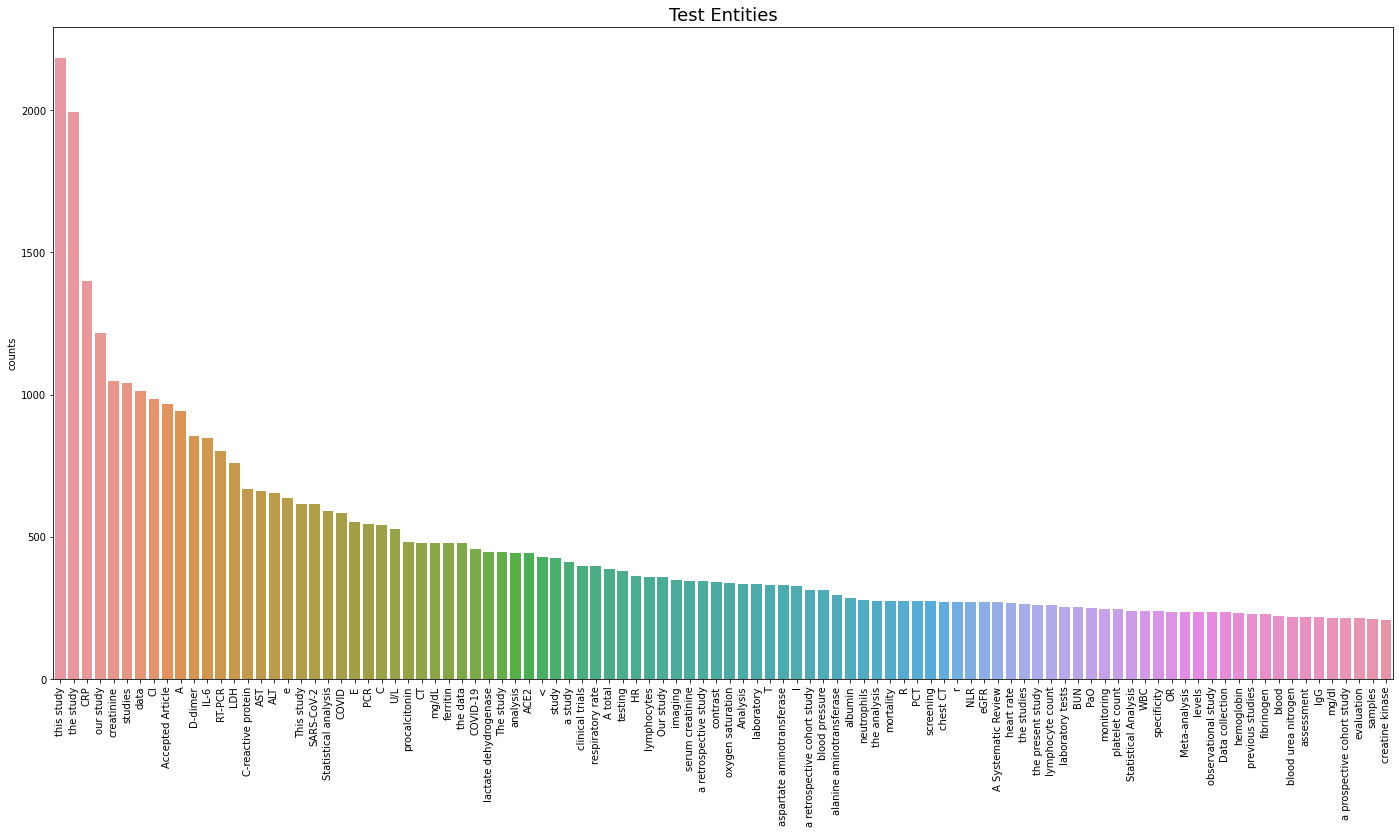

In [444]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart=sns.barplot(testhist2.index,testhist2['counts'])
chart.set_xticklabels(testhist2.index,rotation=90)
plt.title('Test Entities',fontsize=18)
plt.show()

## Look at most frequent "Problem" entities

In [445]:
probhist2.head(40)

,counts
SARS-CoV-2,4749
SARS-CoV-2 infection,2725
death,2431
AKI,2273
fever,2062
hypertension,2059
diabetes,1946
ARDS,1845
infection,1588
the disease,1530


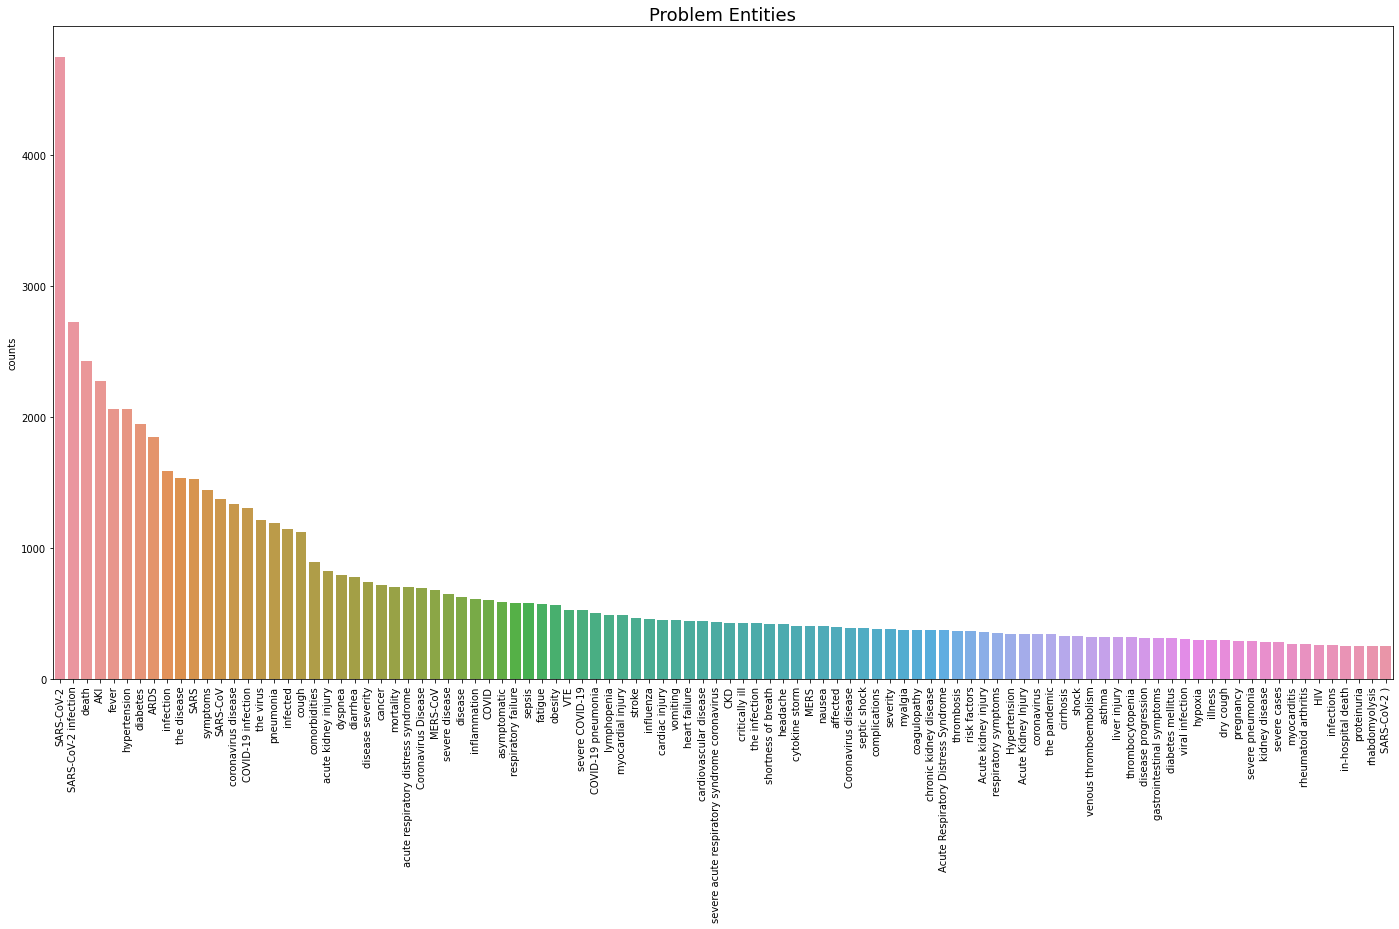

In [446]:
import seaborn as sns
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart=sns.barplot(probhist2.index,probhist2['counts'])
chart.set_xticklabels(probhist2.index,rotation=90)
plt.title('Problem Entities',fontsize=18)
plt.show()

## Find 'Test' entities near the most common kidney related 'Problem' entity

In [447]:
heatdf=problems.merge(tests,on=['docid','section'],how='inner')
heatdf.drop_duplicates(keep='first',inplace=True)
heatdf.head()

,docid,section,sentid_x,token_x,label_x,chunks_x,sentid_y,token_y,label_y,chunks_y
0,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,0,coronavirus,B-PROBLEM,coronavirus disease,4,the,B-TEST,the PaO
1,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,0,coronavirus,B-PROBLEM,coronavirus disease,4,ratio,B-TEST,ratio
2,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,0,coronavirus,B-PROBLEM,coronavirus disease,4,end-expiratory,B-TEST,end-expiratory pressure
3,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,0,coronavirus,B-PROBLEM,coronavirus disease,4,O,B-TEST,O
4,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,0,coronavirus,B-PROBLEM,coronavirus disease,4,body,B-TEST,body weight


In [448]:
heatkid=pd.DataFrame(heatdf[heatdf['chunks_x']=='AKI']).reset_index(drop=True)
heatkid.drop(columns=['section','sentid_x','token_x','label_x','sentid_y','token_y','label_y'],inplace=True)

In [449]:
heatkid.head()

,docid,chunks_x,chunks_y
0,9d01edc73efb22905f896bb00bc60c7a518e958a.json,AKI,COVID-19
1,9d01edc73efb22905f896bb00bc60c7a518e958a.json,AKI,creatinine values
2,9d01edc73efb22905f896bb00bc60c7a518e958a.json,AKI,pregnancy
3,9d01edc73efb22905f896bb00bc60c7a518e958a.json,AKI,serum creatinine
4,9d01edc73efb22905f896bb00bc60c7a518e958a.json,AKI,close monitoring


In [476]:
kidcounts=pd.DataFrame(heatkid.groupby(['chunks_y'])['chunks_x'].count())
kidcounts=kidcounts.sort_values(by='chunks_x',ascending=False)
kidcounts=kidcounts.rename(columns={'chunks_x':'counts'})
kidcounts=kidcounts.iloc[3:25]

In [477]:
kidcounts

,counts
chunks_y,
serum creatinine,259
CI,255
creatinine,238
Our study,222
COVID-19,184
the study,175
ACE2,165
data,152
eGFR,148


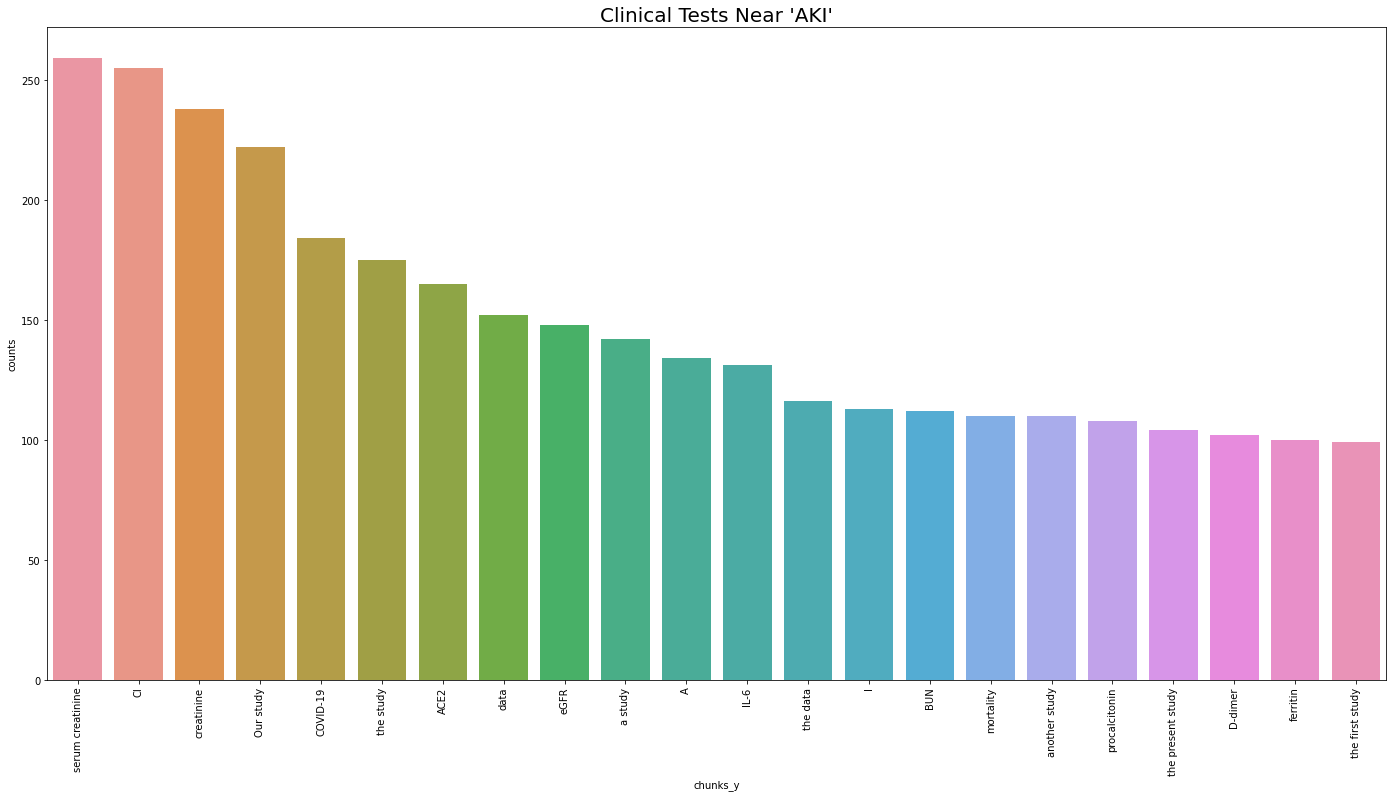

In [453]:
import seaborn as sns
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart= sns.barplot(kidcounts.index,kidcounts['counts'])

chart.set_xticklabels(kidcounts.index,rotation=90)
plt.title("Clinical Tests Near 'AKI'",fontsize=20)


plt.show()

## Find 'Problem' entities near the most common kidney related 'Test' entity

In [454]:
heatcreat=heatdf[heatdf['chunks_y']=='creatinine'].reset_index(drop=True)
heatcreat.drop(columns=['section','sentid_x','token_x','label_x','sentid_y','token_y','label_y'],inplace=True)

In [455]:
creatcounts=pd.DataFrame(heatcreat.groupby(['chunks_x'])['chunks_y'].count())
creatcounts=creatcounts.sort_values(by='chunks_y',ascending=False)
creatcounts=creatcounts.rename(columns={'chunks_y':'counts'})

In [456]:
creatcounts=creatcounts.iloc[0:50]

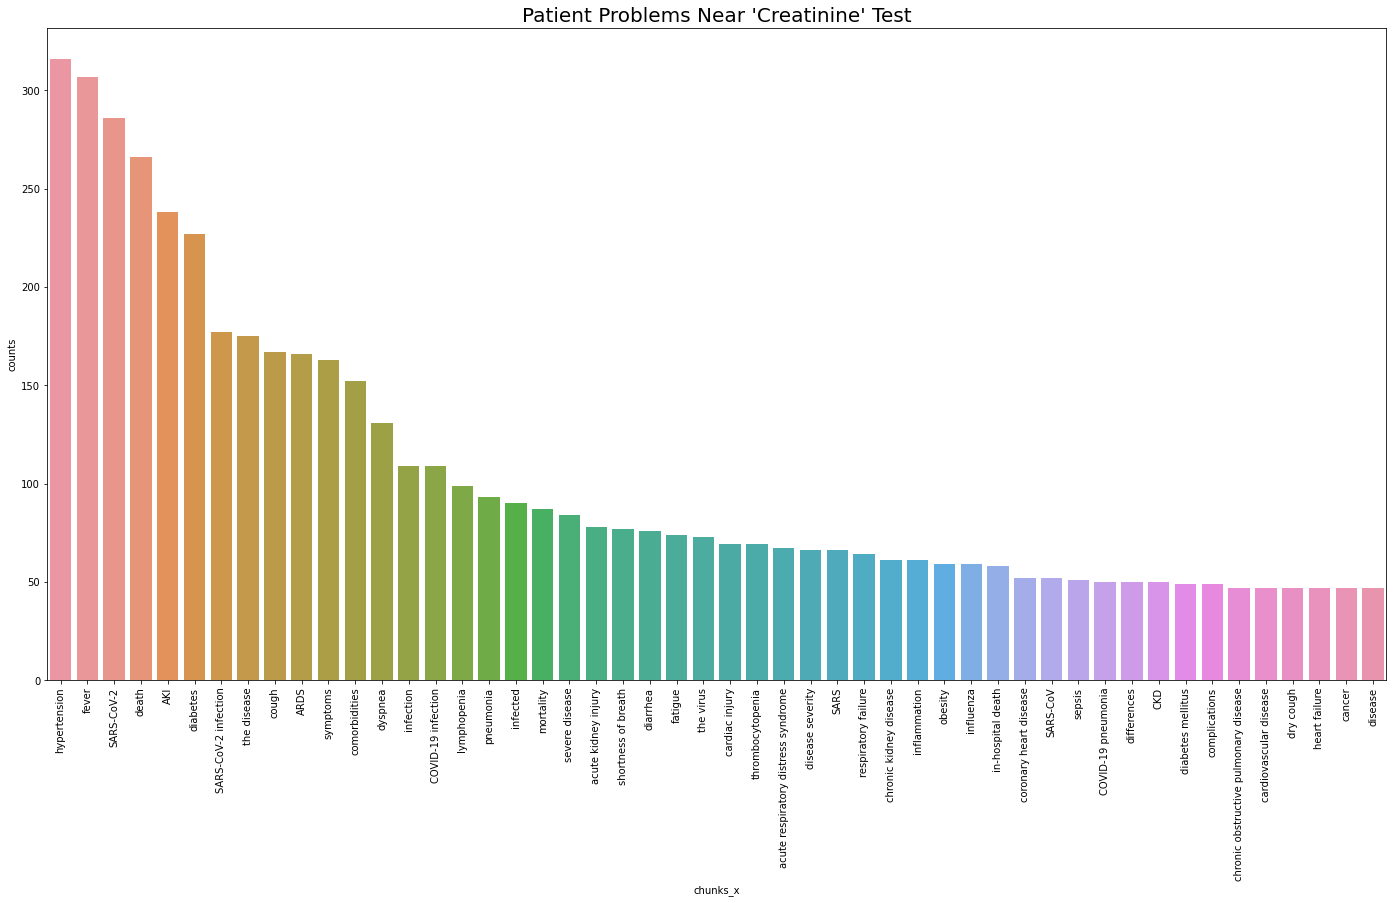

In [457]:
import seaborn as sns
import seaborn as sns
fig, ax = plt.subplots(figsize =(24,12))
chart= sns.barplot(creatcounts.index,creatcounts['counts'])

chart.set_xticklabels(creatcounts.index,rotation=90)
plt.title("Patient Problems Near 'Creatinine' Test",fontsize=20)


plt.show()

## Frequency of 'patient' mentions in documents

In [458]:
patient=pd.DataFrame(big[(big['token'].str.lower()=='patient')|(big['token'].str.lower()=='patients')]).reset_index(drop=True)

In [459]:
patient

,docid,section,sentid,token,label,chunks
0,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,2,patient,O,patient
1,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,2,patient,O,patient
2,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,10,patient,O,patient
3,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,11,patient,O,patient
4,c74590a8197039412e38fdf679cd27ecac01ff72.json,CASE REPORT,12,patient,O,patient
...,...,...,...,...,...,...
83376,3f05ab4d9ea232a44c428a76fdbd86bfbf692216.json,Procedures for Recording and Reporting Serious...,2,patients,O,patients
83377,3f05ab4d9ea232a44c428a76fdbd86bfbf692216.json,Procedures for Recording and Reporting Serious...,6,patient,O,patient
83378,3f05ab4d9ea232a44c428a76fdbd86bfbf692216.json,Procedures for Documenting and Reporting Pregn...,3,patient,O,patient
83379,3f05ab4d9ea232a44c428a76fdbd86bfbf692216.json,REGULATORY APPROVAL,6,patient,O,patient


In [468]:
patients=patient.groupby(['docid'])['token'].count()
patients=patients.reset_index()
patients=patients.rename(columns={'token':'counts'})
len(patients)

1513

Text(0.5, 1.0, 'Frequency of Patient Mentions in 1513 Documents')

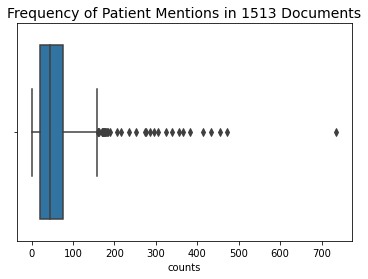

In [479]:
sns.boxplot(patients['counts'])
plt.title('Frequency of Patient Mentions in 1513 Documents',fontsize=14)

## Frequency of 'case report' mentions in documents

In [470]:
case=pd.DataFrame(big[(big['section'].str.lower()=='case report')|(big['section']=='case study')|(big['chunks'].str.lower()=='case report')|(big['chunks'].str.lower()=='case study')|(big['section'].str.lower()=='case reports')|(big['section']=='case studies')|(big['chunks'].str.lower()=='case reports')|(big['chunks'].str.lower()=='case studies')]).reset_index(drop=True)

In [471]:
cases=case.groupby(['docid'])['section'].count()
cases=cases.reset_index()
cases=cases.rename(columns={'section':'counts'})
len(cases)

71

Text(0.5, 1.0, 'Frequency of Case Report/Study Mentions in 71 Documents')

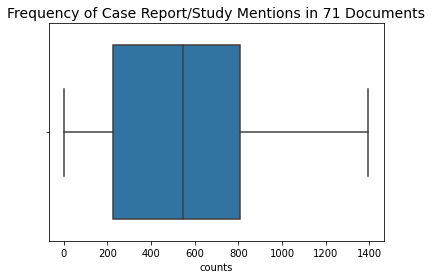

In [478]:
sns.boxplot(cases['counts'])
plt.title('Frequency of Case Report/Study Mentions in 71 Documents',fontsize=14)